In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
df = pd.read_csv('../data/interim/bitcoin_processed.csv')

In [119]:
df.tail()

,Open,High,Low,Close,Quote asset volume,Number of trades,Taker buy quote asset volume
2795,83423.83,85905.00,82792.95,85276.90,1.557403e+09,2501196,8.037473e+08
2796,85276.91,86100.00,83034.23,83760.00,2.086106e+09,3275879,9.863032e+08
2797,83760.00,85799.99,83678.00,84591.58,2.429133e+09,3921522,1.288816e+09
2798,84591.58,86496.42,83600.00,83643.99,1.780972e+09,2910533,8.898958e+08
2799,83643.99,83960.00,83111.64,83487.70,3.655203e+08,638781,1.802272e+08


In [115]:
df.head()

,Open,High,Low,Close,Quote asset volume,Number of trades,Taker buy quote asset volume
0,301.13,312.18,298.00,302.00,2.154655e+06,4522,1.908705e+06
1,302.00,311.79,283.94,293.96,2.858947e+06,5658,2.240813e+06
2,293.31,299.90,278.00,290.91,6.200226e+05,1795,4.447136e+05
3,289.41,300.53,282.85,299.10,7.428479e+05,2038,6.475061e+05
4,299.10,346.52,294.60,323.29,1.689472e+06,3925,1.297977e+06


In [106]:
# sns.pairplot(df)

In [107]:
df.isnull().sum()

Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
price_range                     0
close_to_open                   0
dtype: int64

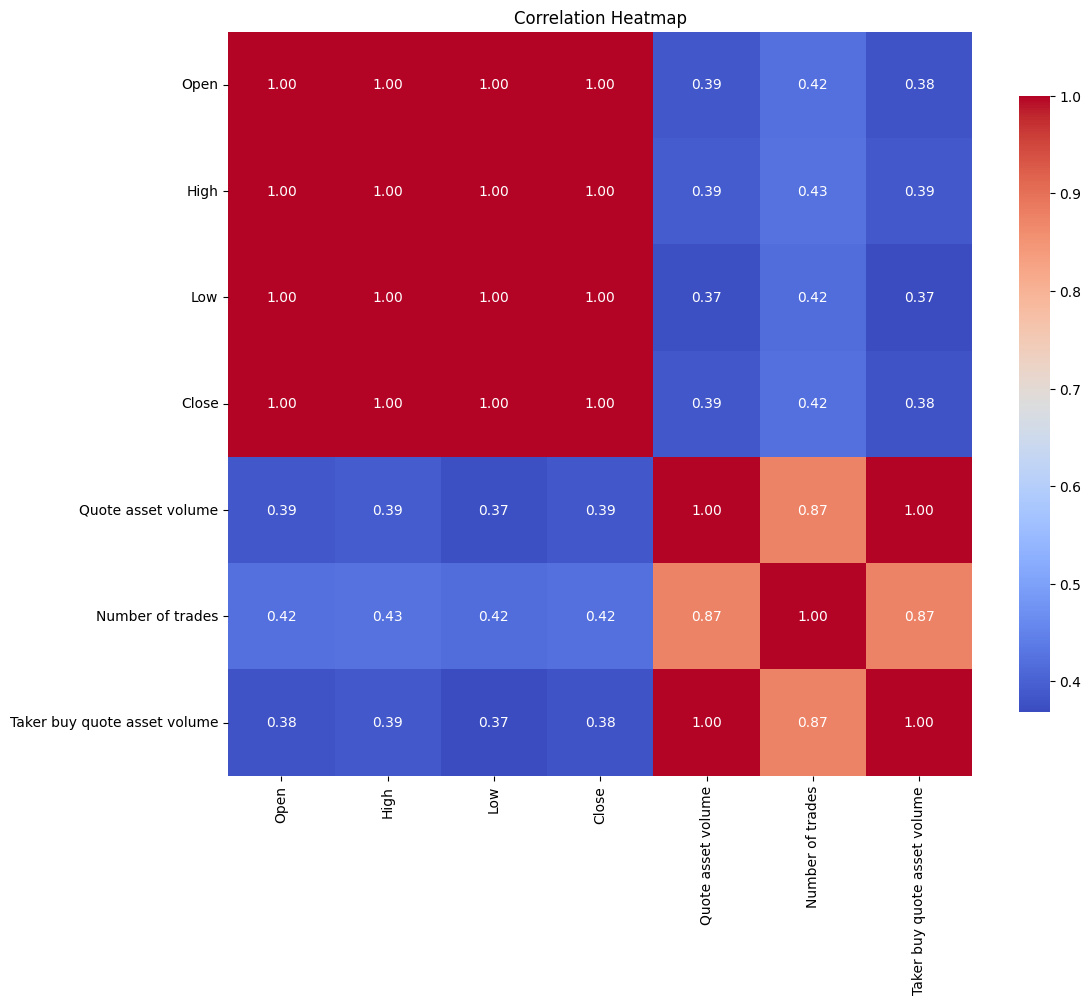

In [120]:
# plot heatmap to know which columns contribute more in predicting the close price
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap")
plt.show()

Mean Squared Error: 603549.2203996559
Root Mean Squared Error: 776.8843030977366
Mean Absolute Error: 531.3796692591472


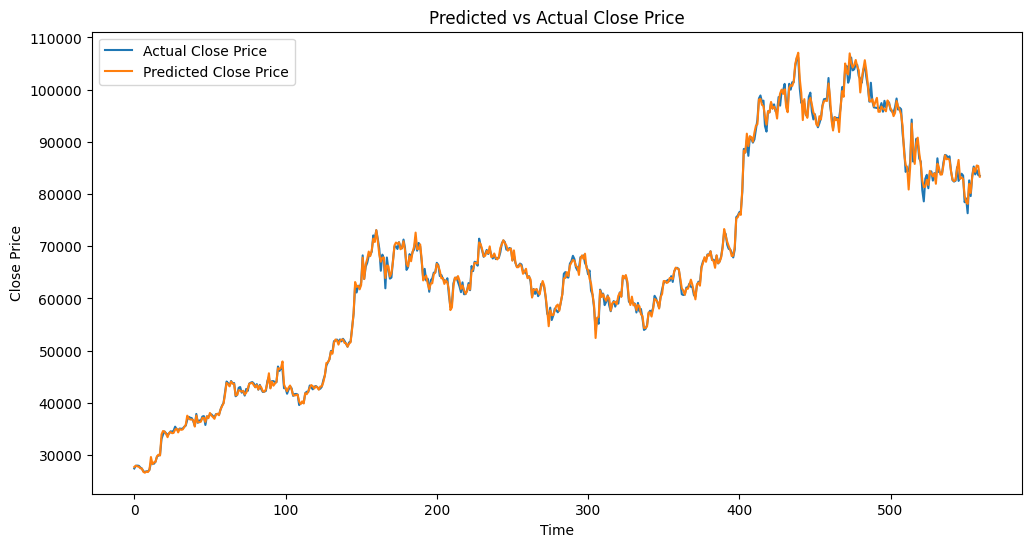

In [121]:
# Let's train linear regression model on the data to predict the close price, we will also scale the data using minmax scaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Split the data into train and test sets
X = df.drop(columns=["Close"]).values
y = df["Close"].values

# we will not use train_test_split as it is time series data so we will use the first 80% of the data for training and the rest for testing
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
# Scale the data using minmax scaler


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the close price
y_pred = model.predict(X_test)

# Calculate the mean squared error and rmse, maean absolute error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")


# Plot the predicted vs actual close price
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Close Price")
plt.plot(y_pred, label="Predicted Close Price")
plt.title("Predicted vs Actual Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [122]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, 
    AdaBoostRegressor, BaggingRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Define models and hyperparameters to tune
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Ridge": (Ridge(), {"alpha": [0.1, 1.0, 10.0]}),
    "Lasso": (Lasso(), {"alpha": [0.1, 1.0, 10.0]}),
    "Elastic Net": (ElasticNet(), {"alpha": [0.1, 1.0, 10.0], "l1_ratio": [0.1, 0.5, 0.9]}),
    "Support Vector Regression": (SVR(), {"C": [0.1, 1, 10], "kernel": ['linear', 'rbf'], "gamma": ['scale', 'auto']}),
    "Random Forest": (RandomForestRegressor(), {"n_estimators": [50, 100], "max_depth": [None, 10, 20]}),
    "Gradient Boosting": (GradientBoostingRegressor(), {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}),
    "AdaBoost": (AdaBoostRegressor(), {"n_estimators": [50, 100]}),
    "Bagging": (BaggingRegressor(), {"n_estimators": [10, 50, 100]}),
    "Decision Tree": (DecisionTreeRegressor(), {"max_depth": [None, 10, 20]}),
    "KNN": (KNeighborsRegressor(), {"n_neighbors": [3, 5, 7]}),
    "XGBoost": (XGBRegressor(), {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}),
    "LightGBM": (LGBMRegressor(), {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]})
}

# Collect model performance results
results_list = []

for name, (model, params) in models.items():
    grid_search = GridSearchCV(model, params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results_list.append({
        "Model": name,
        "Best Params": grid_search.best_params_,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results_list)

# Sort by RMSE for better comparison
results_df = results_df.sort_values(by="RMSE", ascending=True).reset_index(drop=True)

# Print the DataFrame as a table
print(results_df)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\fahim\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e+08, tolerance: 5.639e+07
  model = cd_fast.enet_coordinate_descent(


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2240, number of used features: 6
[LightGBM] [Info] Start training from score 20286.224726
                        Model                                   Best Params  \
0           Linear Regression                                            {}   
1                     

c:\Users\fahim\miniconda3\envs\myenv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


c:\Users\fahim\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+09, tolerance: 5.636e+07
  model = cd_fast.enet_coordinate_descent(


Best Lasso alpha: 10.0
Best Lasso CV Score: 914652.1624161865
Best Ridge alpha: 10.0
Best Ridge CV Score: 914560.3145945005
Lasso Mean Squared Error: 3550515.7989036567
Lasso Root Mean Squared Error: 1884.2812419868899
Lasso Mean Absolute Error: 1311.132675348194
Lasso R2 Score: 0.9914962284367795
Ridge Mean Squared Error: 3551270.2813539216
Ridge Root Mean Squared Error: 1884.48143566179
Ridge Mean Absolute Error: 1311.3944606536777
Ridge R2 Score: 0.9914944213904885


c:\Users\fahim\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.008e+09, tolerance: 5.636e+07
  model = cd_fast.enet_coordinate_descent(


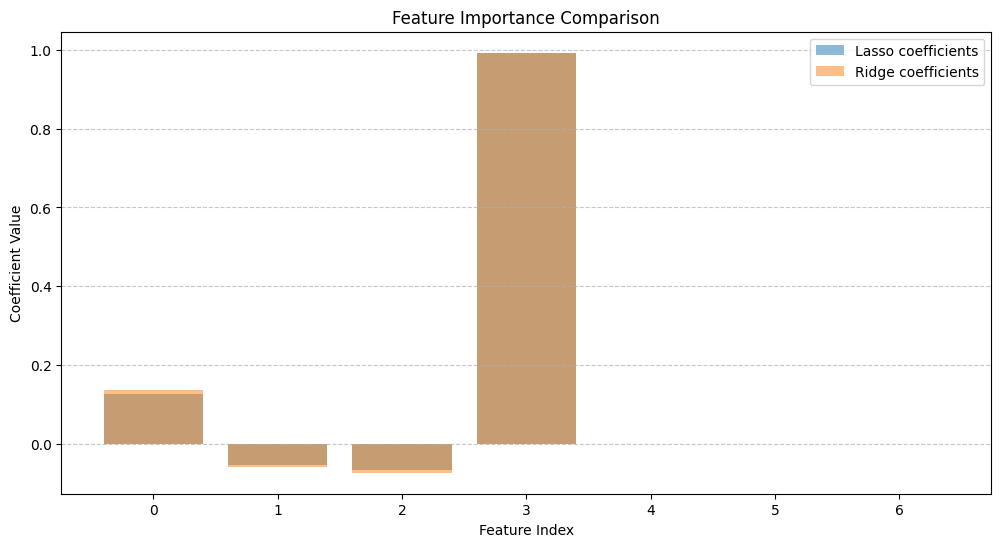

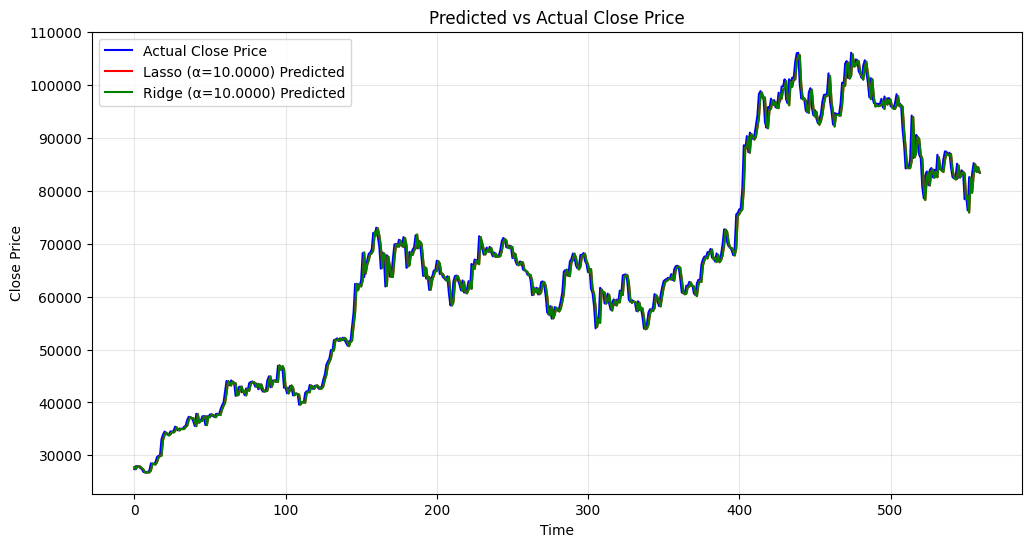

c:\Users\fahim\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e+09, tolerance: 1.389e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\fahim\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e+09, tolerance: 1.433e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\fahim\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

Lasso 5-Fold CV Mean RMSE: 1267.3831180741527
Ridge 5-Fold CV Mean RMSE: 1256.5355397900062


c:\Users\fahim\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e+09, tolerance: 1.708e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\fahim\miniconda3\envs\myenv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.009e+09, tolerance: 5.637e+07
  model = cd_fast.enet_coordinate_descent(


In [124]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df["target"] = df["Close"].shift(-1)
df.dropna(inplace=True)  # Drop the last row with NaN target

# Define your features and target
X = df.drop(columns=["target"])
y = df["target"]

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # Use shuffle=False for time series
)

# Define cross-validation strategy - research indicates 5-10 folds is optimal
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# LASSO hyperparameter tuning
lasso_params = {
    'alpha': np.logspace(-4, 1, 50)
}

lasso_grid = GridSearchCV(
    Lasso(max_iter=10000, random_state=42),
    lasso_params,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

lasso_grid.fit(X_train, y_train)
best_lasso_alpha = lasso_grid.best_params_['alpha']
print(f"Best Lasso alpha: {best_lasso_alpha}")
print(f"Best Lasso CV Score: {-lasso_grid.best_score_}")

# RIDGE hyperparameter tuning
ridge_params = {
    'alpha': np.logspace(-4, 1, 50)
}

ridge_grid = GridSearchCV(
    Ridge(max_iter=10000, random_state=42),
    ridge_params,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)
best_ridge_alpha = ridge_grid.best_params_['alpha']
print(f"Best Ridge alpha: {best_ridge_alpha}")
print(f"Best Ridge CV Score: {-ridge_grid.best_score_}")

# Train the models with the best parameters
lasso = Lasso(alpha=best_lasso_alpha, max_iter=10000, random_state=42)
lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_mae = mean_absolute_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)
print(f"Lasso Mean Squared Error: {lasso_mse}")
print(f"Lasso Root Mean Squared Error: {lasso_rmse}")
print(f"Lasso Mean Absolute Error: {lasso_mae}")
print(f"Lasso R2 Score: {lasso_r2}")

ridge = Ridge(alpha=best_ridge_alpha, max_iter=10000, random_state=42)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)
print(f"Ridge Mean Squared Error: {ridge_mse}")
print(f"Ridge Root Mean Squared Error: {ridge_rmse}")
print(f"Ridge Mean Absolute Error: {ridge_mae}")
print(f"Ridge R2 Score: {ridge_r2}")

# Compare the feature importance
if X_train.shape[1] <= 20:
    plt.figure(figsize=(12, 6))
    feature_names = range(X_train.shape[1])
    plt.bar(feature_names, lasso.coef_, alpha=0.5, label='Lasso coefficients')
    plt.bar(feature_names, ridge.coef_, alpha=0.5, label='Ridge coefficients')
    plt.legend()
    plt.title('Feature Importance Comparison')
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.xticks(feature_names)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot the predicted vs actual close price for lasso and ridge
plt.figure(figsize=(12, 6))
plt.plot(y_test.values if hasattr(y_test, 'values') else y_test, label="Actual Close Price", color='blue')
plt.plot(lasso_pred, label=f"Lasso (α={best_lasso_alpha:.4f}) Predicted", color='red')
plt.plot(ridge_pred, label=f"Ridge (α={best_ridge_alpha:.4f}) Predicted", color='green')
plt.title("Predicted vs Actual Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Evaluate models with cross-validation to ensure robustness
from sklearn.model_selection import cross_val_score

lasso_cv_scores = cross_val_score(
    Lasso(alpha=best_lasso_alpha, max_iter=10000, random_state=42),
    np.concatenate((X_train, X_test)),
    np.concatenate((y_train, y_test)),
    cv=5,
    scoring='neg_mean_squared_error'
)

ridge_cv_scores = cross_val_score(
    Ridge(alpha=best_ridge_alpha, max_iter=10000, random_state=42),
    np.concatenate((X_train, X_test)),
    np.concatenate((y_train, y_test)),
    cv=5,
    scoring='neg_mean_squared_error'
)

print(f"Lasso 5-Fold CV Mean RMSE: {np.sqrt(-lasso_cv_scores.mean())}")
print(f"Ridge 5-Fold CV Mean RMSE: {np.sqrt(-ridge_cv_scores.mean())}")
